In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import albumentations as A
# ↑ Error 발생시, 조치 요령
# 명령 프롬프트 - 관리자 권한으로 실행
# ctrl + c 여러번 눌러서 실행 중지
# pip install albumentations 입력
# 설치 완료 후 jupyter notebook 입력
import torchvision
import torch.nn as nn

from util import CLASS_NAME_TO_ID, visualize, save_model
from ipywidgets import interact
from albumentations.pytorch import ToTensorV2
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from time import time

In [2]:
data_dir = './DataSet/'
data_dir_train = './DataSet/train/'

data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))

In [3]:
data_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


In [4]:
index = 3
image_files = [fn for fn in os.listdir(data_dir_train) if fn.endswith('jpg')]
image_file = image_files[index]
image_file

'00013f14dd4e168f.jpg'

In [5]:
image_path = os.path.join(data_dir_train, image_file)
image_path

'./DataSet/train/00013f14dd4e168f.jpg'

In [6]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape # h, w, c

(171, 256, 3)

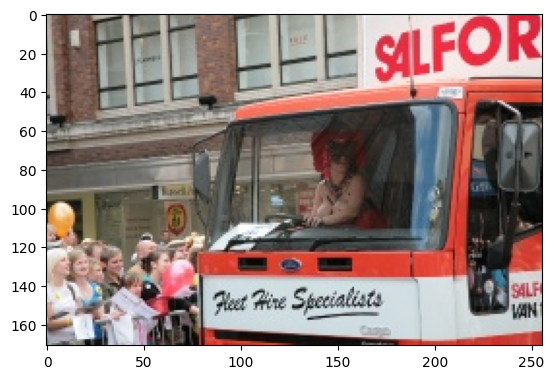

In [7]:
plt.imshow(image)

In [8]:
image_id = image_file.split('.')[0]
image_id

'00013f14dd4e168f'

In [9]:
meta_data = data_df[data_df['ImageID'] == image_id]
meta_data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
4,00013f14dd4e168f,xclick,Bus,1,0.2875,0.999375,0.194184,0.999062,0,1,...,0,0,0.92,0.999375,0.64875,0.2875,0.194184,0.30394,0.999062,0.523452


In [10]:
cate_names = meta_data['LabelName'].values
cate_names

array(['Bus'], dtype=object)

In [11]:
bboxes = meta_data[['XMin','XMax', 'YMin', 'YMax']].values
bboxes

array([[0.2875  , 0.999375, 0.194184, 0.999062]])

In [12]:
img_H, img_W, _ = image.shape
print(img_H)
print(img_W)

171
256


In [13]:
class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
class_ids

[0]

In [14]:
unnorm_bboxes = bboxes.copy()
unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
unnorm_bboxes[:, [0, 2]] *= img_W
unnorm_bboxes[:, [1, 3]] *= img_H

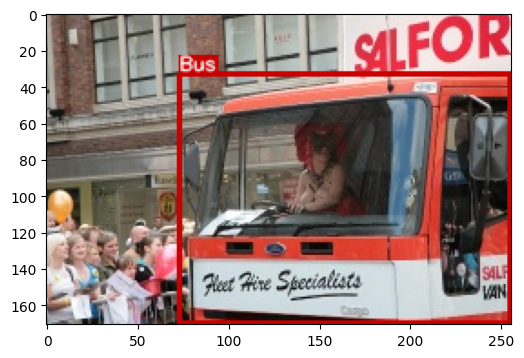

In [15]:
canvas = visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [16]:
@interact(index=(0, len(image_files) - 1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join(data_dir_train, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    cate_names = meta_data['LabelName'].values
    bboxes = meta_data[['XMin','XMax', 'YMin', 'YMax']].values
    img_H, img_W, _ = image.shape
    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
    unnorm_bboxes[:, [0, 2]] *= img_W
    unnorm_bboxes[:, [1, 3]] *= img_H

    canvas = visualize(image, unnorm_bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [17]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase # train or bus
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transformer = transformer

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        if self.transformer:
            transformed_data = self.transformer(image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed_data['image']
            bboxes = np.array(transformed_data['bboxes'])
            class_ids = np.array(transformed_data['class_ids'])
        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        return image, target, filename
    
    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
    
    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = self.data_df[self.data_df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])
        bboxes = meta_data[['XMin','XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]]
        bboxes[:, 2:4] -= bboxes[:, 0:2]
        bboxes[:, 0:2] += (bboxes[:, 2:4]/2)
        return bboxes, class_ids
        

In [18]:
dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=None)
dataset[3]

(array([[[177, 170, 162],
         [175, 166, 157],
         [152, 135, 127],
         ...,
         [197,  53,  80],
         [255, 182, 196],
         [255, 217, 224]],
 
        [[179, 172, 164],
         [178, 168, 159],
         [158, 141, 133],
         ...,
         [200,  50,  77],
         [201, 110, 127],
         [255, 211, 221]],
 
        [[180, 171, 164],
         [178, 168, 159],
         [167, 148, 141],
         ...,
         [201,  41,  67],
         [180,  64,  85],
         [255, 195, 213]],
 
        ...,
 
        [[119, 129, 131],
         [153, 160, 166],
         [164, 166, 178],
         ...,
         [193,  52,  43],
         [193,  50,  42],
         [193,  51,  41]],
 
        [[109, 123, 126],
         [145, 156, 160],
         [165, 170, 176],
         ...,
         [196,  53,  45],
         [195,  51,  42],
         [195,  51,  42]],
 
        [[101, 119, 119],
         [157, 171, 171],
         [162, 167, 170],
         ...,
         [199,  55,  46],
  

In [19]:
index = 3
image, target, filename = dataset[index]
img_H, img_W, _ = image.shape

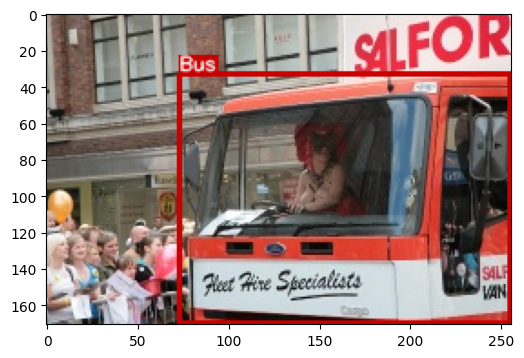

In [20]:
bboxes = target[:, 0:4]
class_ids = target[:, 4]
bboxes[:, [0, 2]] *= img_W
bboxes[:, [1, 3]] *= img_H

canvas = visualize(image, bboxes, class_ids)
plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [21]:
@interact(index=(0, len(dataset) - 1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    img_H, img_W, _ = image.shape
    
    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    bboxes[:, [0, 2]] *= img_W
    bboxes[:, [1, 3]] *= img_H

    canvas = visualize(image, bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [22]:
IMAGE_SIZE = 448

transformer = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']))

In [23]:
transformed_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)

In [24]:
@interact(index=(0, len(transformed_dataset) - 1))
def show_sample(index=0):
    image, target, filename = transformed_dataset[index]
    _, img_H, img_W = image.shape
    
    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    bboxes[:, [0, 2]] *= img_W
    bboxes[:, [1, 3]] *= img_H

    np_image = make_grid(image, normalize=True).cpu().permute(1,2,0).numpy()
    canvas = visualize(np_image, bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [25]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []
    
    for image, target, filename in batch:
        image_list.append(image)
        target_list.append(target)
        filename_list.append(filename)
    
    return torch.stack(image_list, dim=0), target_list, filename_list

In [26]:
BATCH_SIZE = 1

trainset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [27]:
for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    
    if index == 0:
        break

In [28]:
filenames

['40d0de94f9a9bec5.jpg']

In [29]:
def build_dataloader(data_dir, batch_size=4):
    transformer = A.Compose([
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']),
    )

    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = Detection_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [30]:
BATCH_SIZE = 2
dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)

In [31]:
for phase in ["train", "val"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(images.shape)
        print(targets)
        if index == 0:
            break

torch.Size([2, 3, 448, 448])
[array([[0.430625 , 0.5910365, 0.6375   , 0.466853 , 1.       ]]), array([[0.6021875, 0.6265625, 0.758125 , 0.615625 , 1.       ]])]
torch.Size([1, 3, 448, 448])
[array([[0.4290625, 0.6477485, 0.496875 , 0.462477 , 1.       ]])]


<img src='https://velog.velcdn.com/images%2Fraziel%2Fpost%2F901df3ee-6aaf-468b-9991-072aeed00381%2Fimage.png' width=600>

In [32]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
# resnet18 모델의 layer가 1 ~ 4까지 존재하는데 어디까지 사용할 것인지 결정
layers = [m for m in resnet18.children()]
layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [34]:
testnet = nn.Sequential(*layers[:-2])
testnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [35]:
temp_x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE) # (B, C, W, H) -> 1, 3, 448, 448
# temp_x
temp_y = testnet(temp_x)
temp_y.shape

torch.Size([1, 512, 14, 14])

In [36]:
class YOLOv1_RESNET(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        num_classes = num_classes
        num_bboxes = 2
        grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained=True)
        layers = [m for m in resnet18.children()]

        self.backbone = nn.Sequential(*layers[:-2])

        self.head = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=(4+1)*num_bboxes+num_classes, kernel_size=1, padding=0, bias=False),
            nn.AdaptiveAvgPool2d(output_size=(grid_size, grid_size))
        )

    def forward(self, x):
        out = self.backbone(x)
        out = self.head(out)
        return out

In [37]:
NUM_CLASSES = 2
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)
model

YOLOv1_RESNET(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [38]:
x = torch.randn(1, 3, 448, 448)
with torch.no_grad():
    y = model(x)
print(y.shape)

torch.Size([1, 12, 7, 7])


In [39]:
BATCH_SIZE = 2

trainset = Detection_dataset(data_dir=data_dir, phase="train",
                             transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=collate_fn)
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)

for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    predictions = model(images)
    print(f'input shape: {image.shape} -> output shape: {predictions.shape}')
    if index == 3:
        break

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


input shape: (171, 256, 3) -> output shape: torch.Size([2, 12, 7, 7])
input shape: (171, 256, 3) -> output shape: torch.Size([2, 12, 7, 7])
input shape: (171, 256, 3) -> output shape: torch.Size([2, 12, 7, 7])
input shape: (171, 256, 3) -> output shape: torch.Size([2, 12, 7, 7])


In [40]:
predictions

tensor([[[[ 3.7114e-01,  2.1172e-01,  1.5220e-01,  ...,  4.0876e-01,
            5.3424e-01,  2.6032e-01],
          [ 2.8734e-01,  3.1233e-01,  2.1799e-01,  ...,  6.1790e-01,
            9.5747e-01,  2.3793e-01],
          [ 7.4409e-01,  6.3984e-01,  7.5365e-01,  ...,  3.2744e-01,
            2.2860e-01,  3.2797e-01],
          ...,
          [ 6.1589e-01,  5.8578e-01,  8.0146e-01,  ...,  1.0603e-01,
            2.1785e-01,  1.7865e-01],
          [ 7.7254e-01,  1.7828e-01,  7.6186e-01,  ...,  4.4378e-01,
            5.9567e-01,  1.9275e-01],
          [ 4.9951e-01,  3.3617e-01,  1.4592e-01,  ...,  4.2352e-01,
            2.4626e-01,  2.0786e-01]],

         [[-2.5732e-01,  2.5041e-01,  2.9798e-01,  ...,  2.9332e-01,
            2.9689e-01,  1.6858e-01],
          [-2.2379e-01,  2.7788e-03,  5.1817e-01,  ..., -1.4665e-01,
           -3.7328e-01,  1.0583e-01],
          [-1.1567e-02,  3.7090e-01,  9.3939e-02,  ..., -3.8162e-02,
           -2.0723e-01,  5.4169e-02],
          ...,
     

In [41]:
num_classes = 2
grid_size = 7
device = torch.device('cpu')

In [42]:
# target: n * [x_center, y_center, width, height, class_id]
# output: 448*448*3 크기의 input값을 입력 -> 7*7*12
# target에 넣은 데이터를 비교가 가능한 동일한 매트릭스로 만들기
def build_target_grid(target):
    # target -> 7 * 7 * 7 포멧으로 변경
    # 7 = (1 + 4) + 2
    # bus -> [1, xc, yc, w, h, 1, 0]
    # truck -> [1, xc, yc, w, h, 0, 1]
    # 7(objectness + bounding_box + class) * 7(grid_size) * 7(grid_size)
    target_grid = torch.zeros((1+4+num_classes, grid_size, grid_size), device=device)
    
    for gt in target:
        xc, yc, w, h, cls_id = gt
        # xn, yn: 7*7 그리드에서 몇번째 칸에 있는지를 확인하기 위한 계산
        xn = (xc % (1/grid_size))
        yn = (yc % (1/grid_size))
        cls_id = int(cls_id)
        
        i_grid = int(xc * grid_size)
        j_grid = int(yc * grid_size)
        target_grid[0, j_grid, i_grid] = 1
        target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn, yn, w, h])
        target_grid[5+cls_id, j_grid, i_grid] = 1
        
    return target_grid        

In [43]:
def build_batch_target_grid(targets):
    # target_grid_batch = torch.stack(target) # [[xc, yc, w, h], [xc, yc, w, h], [xc, yc, w, h].. ]
    # target_grid_batch.shape: [batch_size, 7, 7, 7]
    target_grid_batch = torch.stack([build_target_grid(target) for target in targets], dim=0)
    return target_grid_batch

In [44]:
targets

[array([[0.111875 , 0.25536  , 0.1525   , 0.130934 , 1.       ],
        [0.4959375, 0.540582 , 0.803125 , 0.787136 , 1.       ],
        [0.93     , 0.320061 , 0.13875  , 0.140888 , 1.       ]]),
 array([[0.35     , 0.5933335, 0.7      , 0.811111 , 1.       ]])]

In [45]:
len(targets)

2

In [46]:
groundtruths = build_batch_target_grid(targets)
groundtruths.shape

torch.Size([2, 7, 7, 7])

In [47]:
groundtruths[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1119, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0729],
         [0.0000, 0.0000, 0.0000, 0.0674, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

In [48]:
1 / grid_size

0.14285714285714285

In [49]:
0.5296875 * 7

3.7078124999999997

In [50]:
0.5363425 * 7

3.7543975000000005

In [51]:
0.5296875 % 0.1428

0.10128749999999995

In [52]:
# IoU 구하기
# xn, yn, w, h -> xmin, ymin, xmax, ymax 바꿈(겹쳐지는 영역의 비율을 계산)
# xywh -> xyxy
# 교집합과 합집합의 영역을 구함 -> 교집합 비율을 구함

def get_IoU(cbox1, cbox2):
    box1 = xywh_to_xyxy(cbox1)
    box2 = xywh_to_xyxy(cbox2)
    
    # 교집합 영역 구하는 부분
    x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...]) # 오른쪽
    y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...]) # 아래쪽
    x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...]) # 왼쪽
    y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...]) # 위쪽
    
    # clamp(): 텐서의 값을 주어진 범위 내로 조정하는 역할
    intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
    union = abs(cbox1[:, 2, ...] * cbox1[:, 3, ...]) + abs(cbox2[:, 2, ...] * cbox2[:, 3, ...]) - intersection
    # gt(), eq(), lt()
    intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
    return intersection

In [53]:
def xywh_to_xyxy(bboxes):
    # bboxes: [xn, yn, w, h]
    # print('bboxes: ', bboxes.shape) # 2, 4, 7, 7
    num_batch, _, grid_size, grid_size = bboxes.shape
    xy_normed_grid = generate_xy_normed_grid(grid_size=grid_size)
    # print('xy_normed_grid: ', xy_normed_grid.shape)
    # tile(): 텐서를 복사하여 주어진 차원에 따라 반복하는 역할
    xcyc = bboxes[:, 0:2, ...] + xy_normed_grid.tile(num_batch, 1, 1, 1) # 2, 2, 7, 7 만들기
    wh = bboxes[:, 2:4, ...]
    x1y1 = xcyc - (wh/2)
    x2y2 = xcyc + (wh/2)
    return torch.cat([x1y1, x2y2], dim=1)

In [54]:
def generate_xy_normed_grid(grid_size):
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    xy_grid = torch.stack([x_offset, y_offset], dim=0)
    xy_normed_grid = xy_grid / grid_size
    return xy_normed_grid

In [55]:
iou1 = get_IoU(predictions[:, 1:5, ...], groundtruths[:, 1:5, ...])
iou2 = get_IoU(predictions[:, 6:10, ...], groundtruths[:, 1:5, ...])

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [56]:
iou1

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], grad_fn=<IndexPutBackward0>)

In [57]:
iou2

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], grad_fn=<IndexPutBackward0>)

In [58]:
ious = torch.stack([iou1, iou2], dim=1) # batch_size, iou, grid, grid
print(ious.shape)

torch.Size([2, 2, 7, 7])


In [59]:
max_iou, best_box = ious.max(dim=1, keepdim=True)
# print('max_iou: ', max_iou)
# print('best_box: ', best_box)
max_iou = torch.cat([max_iou, max_iou], dim=1)
best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)

In [60]:
# batch_size, 10, 7, 7 -> batch_size, 2, 5, 7, 7
predictions_ = predictions[:, :5*2, ...].reshape(BATCH_SIZE, 2, 5, grid_size, grid_size)
obj_pred = predictions_[:, :, 0, ...]
xy_pred = predictions_[:, :, 1:3, ...]
wh_pred = predictions_[:, :, 3:5, ...]
cls_pred = predictions[:, 5*2, ...]

In [61]:
groundtruths_ = groundtruths[:, :5, ...].reshape(BATCH_SIZE, 1, 5, grid_size, grid_size)
obj_target = groundtruths_[:, :, 0, ...]
xy_target = groundtruths_[:, :, 1:3, ...]
wh_target = groundtruths_[:, :, 3:5, ...]
cls_target = groundtruths[:, 5, ...]

In [62]:
positive = obj_target * best_box

In [63]:
mse_loss = nn.MSELoss(reduction='sum')

In [64]:
positive

tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0

In [65]:
positive.shape

torch.Size([2, 2, 7, 7])

In [66]:
obj_loss = mse_loss(positive * obj_pred, positive * ious)
noobj_loss = mse_loss((1 - positive) * obj_pred, ious * 0)
# positive: [2, 2, 7, 7], batch_size, Box, Grid, Grid -> [2, 2, ?, 7, 7]
# xy_pred: [2, 2, 2, 7, 7], batch_size, Box, XY, Grid, Grid
xy_loss = mse_loss(positive.unsqueeze(dim=2) * xy_pred, positive.unsqueeze(dim=2))
wh_loss = mse_loss(positive.unsqueeze(dim=2) * (wh_pred.sign() * (wh_pred.abs() + 1e-8).sqrt()),
                  positive.unsqueeze(dim=2) * (wh_target + 1e-8).sqrt())
cls_loss = mse_loss(obj_target * cls_pred, cls_target)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 2, 1, 7, 7])) that is different to the input size (torch.Size([2, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 7, 7])) that is different to the input size (torch.Size([2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [67]:
xy_pred.shape

torch.Size([2, 2, 2, 7, 7])

In [68]:
class YOLOv1_LOSS():
    # 모델과 데이터셋의 특성에 따라 달라짐. 실험과 검증을 통해 최적의 값을 결정
    # lambda_noobj: 객체 탐지에서 사용하는 하이퍼파라미터. 배경 영역에 대한 손실 계산시 가중치 조절을 하는 역할
    # lambda_coord: 객체 탐지에서 사용되는 하이퍼파라미터. 객체의 경계 상자좌표에 대한 손실계산 시 가중치 조절하는 역할
    def __init__(self, num_classes, device, lambda_coord=5., lambda_noobj=0.5):
        self.num_classes = num_classes
        self.device = device
        self.grid_size = 7
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss(reduction='sum')
    
    def __call__(self, predictions, targets):
        self.batch_size, _, _, _ = predictions.shape
        groundtruths = self.build_batch_target_grid(targets)
        groundtruths = groundtruths.to(self.device)
        
        with torch.no_grad():
            iou1 = get_IoU(predictions[:, 1:5, ...], groundtruths[:, 1:5, ...])
            iou2 = get_IoU(predictions[:, 6:10, ...], groundtruths[:, 1:5, ...])
    
        ious = torch.stack([iou1, iou2], dim=1)
        max_iou, best_box = ious.max(dim=1, keepdim=True)
        max_iou = torch.cat([max_iou, max_iou], dim=1)
        best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)
        
        predictions_ = predictions[:, :5*2, ...].reshape(self.batch_size, 2, 5, self.grid_size, self.grid_size)
        obj_pred = predictions_[:, :, 0, ...]
        xy_pred = predictions_[:, :, 1:3, ...]
        wh_pred = predictions_[:, :, 3:5, ...]
        cls_pred = predictions[:, 5*2, ...]
        
        groundtruths_ = groundtruths[:, :5, ...].reshape(self.batch_size, 1, 5, self.grid_size, self.grid_size)
        obj_target = groundtruths_[:, :, 0, ...]
        xy_target = groundtruths_[:, :, 1:3, ...]
        wh_target = groundtruths_[:, :, 3:5, ...]
        cls_target = groundtruths[:, 5, ...]
        
        positive = obj_target * best_box
        
        obj_loss = self.mse_loss(positive * obj_pred, positive * ious)
        noobj_loss = self.mse_loss((1 - positive) * obj_pred, ious * 0)
        xy_loss = self.mse_loss(positive.unsqueeze(dim=2) * xy_pred, positive.unsqueeze(dim=2))
        wh_loss = self.mse_loss(positive.unsqueeze(dim=2) * (wh_pred.sign() * (wh_pred.abs() + 1e-8).sqrt()),
                          positive.unsqueeze(dim=2) * (wh_target + 1e-8).sqrt())
        cls_loss = self.mse_loss(obj_target * cls_pred, cls_target)
        
        obj_loss /= self.batch_size
        noobj_loss /= self.batch_size
        bbox_loss = (xy_loss+wh_loss) / self.batch_size
        cls_loss /= self.batch_size
        
        total_loss = obj_loss + self.lambda_noobj*noobj_loss + self.lambda_coord*bbox_loss + cls_loss
        return total_loss, (obj_loss.item(), noobj_loss.item(), bbox_loss.item(), cls_loss.item())
    
    def build_batch_target_grid(self, targets):
        target_grid_batch = torch.stack([self.build_target_grid(target) for target in targets], dim=0)
        return target_grid_batch

    def build_target_grid(self, target):
        target_grid = torch.zeros((1+4+self.num_classes, self.grid_size, self.grid_size), device=self.device)

        for gt in target:
            xc, yc, w, h, cls_id = gt
            xn = (xc % (1/self.grid_size))
            yn = (yc % (1/self.grid_size))
            cls_id = int(cls_id)

            i_grid = int(xc * self.grid_size)
            j_grid = int(yc * self.grid_size)
            target_grid[0, j_grid, i_grid] = 1
            target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn, yn, w, h])
            target_grid[5+cls_id, j_grid, i_grid] = 1

        return target_grid

    def get_IoU(self, cbox1, cbox2):
        box1 = self.xywh_to_xyxy(cbox1)
        box2 = self.xywh_to_xyxy(cbox2)

        x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...])
        y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
        x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
        y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

        intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
        union = abs(cbox1[:, 2, ...] * cbox1[:, 3, ...]) + abs(cbox2[:, 2, ...] * cbox2[:, 3, ...]) - intersection

        intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
        return intersection
    
    def xywh_to_xyxy(self, bboxes):
        xy_normed_grid = self.generate_xy_normed_grid()
        xcyc = bboxes[:, 0:2, ...] + xy_normed_grid.tile(self.batch_size, 1, 1, 1)
        wh = bboxes[:, 2:4, ...]
        x1y1 = xcyc - (wh/2)
        x2y2 = xcyc + (wh/2)
        return torch.cat([x1y1, x2y2], dim=1)

    def generate_xy_normed_grid(self):
        y_offset, x_offset = torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size))
        xy_grid = torch.stack([x_offset, y_offset], dim=0)
        xy_normed_grid = xy_grid / self.grid_size
        return xy_normed_grid.to(self.device)

In [69]:
is_cuda = False
BATCH_SIZE = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

trainset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)
criterion = YOLOv1_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
# weight_decay: 가중치 업데이트시 L2 정규화를 수행하는데 사용되는 하이퍼라미터, 가중치 감쇠라고도 불림
# L2정규화는 가중치의 제곱합을 손실 함수에 추가하여 가중치의 크기가 크지 않도록 제한
# 일반화 능력을 향상시키고, 과적합을 줄일 수 있음
optimzer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4)

for index, batch in enumerate(trainloader):
    images = batch[0].to(DEVICE)
    targets = batch[1]
    filenames = batch[2]
    
    predictions = model(images)
    loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)
    
    print(loss, obj_loss, noobj_loss, bbox_loss, cls_loss)
    
    if index == 0:
        break

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(45.7553, grad_fn=<AddBackward0>) 0.23096755146980286 16.70780372619629 7.02431583404541 2.0488064289093018


C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 2, 1, 7, 7])) that is different to the input size (torch.Size([2, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 7, 7])) that is different to the input size (torch.Size([2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [70]:
loss

tensor(45.7553, grad_fn=<AddBackward0>)

In [71]:
from collections import defaultdict

In [72]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
    
    running_loss = defaultdict(float)
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0].to(device)
        targets = batch[1]
        filenames = batch[2]
        
        with torch.set_grad_enabled(phase == 'train'):
            predictions = model(images)
        
        loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)
        
        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss['total_loss'] += loss.item()
            running_loss['obj_loss'] += obj_loss
            running_loss['noobj_loss'] += noobj_loss
            running_loss['bbox_loss'] += bbox_loss
            running_loss['cls_loss'] += cls_loss
            
            train_loss['total_loss'] += loss.item()
            train_loss['obj_loss'] += obj_loss
            train_loss['noobj_loss'] += noobj_loss
            train_loss['bbox_loss'] += bbox_loss
            train_loss['cls_loss'] += cls_loss
            
            if(index > 0) and (index % VERBOSE_FREQ) == 0:
                text = f'iteration:[{index}/{len(dataloaders[phase])}] - '
                for k, v in running_loss.item():
                    text += f'{k}: {v/VERBOSE_FREQ:.4f} '
                    running_loss[k] = 0.
                print(text)
        
        else:
            val_loss['total_loss'] += loss.item()
            val_loss['obj_loss'] += obj_loss
            val_loss['noobj_loss'] += noobj_loss
            val_loss['bbox_loss'] += bbox_loss
            val_loss['cls_loss'] += cls_loss
    
    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])
    return train_loss, val_loss

In [73]:
is_cuda = False

NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 12
VERBOSE_FREQ = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = YOLOv1_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
num_epochs = 100

best_epoch = 0
best_score = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"epoch:{epoch+1}/{num_epochs} - Train Loss: {train_loss['total_loss']:.4f}, Val Loss: {val_loss['total_loss']:.4f}")
    
    if (epoch+1) % 10 == 0:
        save_model(model.state_dict(), f'model_{epoch+1}.pth')

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1, 7, 7])) that is different to the input size (torch.Size([1, 2, 2, 

KeyboardInterrupt: 

In [75]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = YOLOv1_RESNET(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [76]:
transformer = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [77]:
ckpt_path = "./trained_model/model_100.pth"
DEVICE = torch.device("cpu")
model = load_model(ckpt_path, NUM_CLASSES, device)

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
@torch.no_grad()
def model_predict(image, model, conf_thres=0.3, iou_threshold=0.1):
    tf_data = transformer(image=image)
    tensor_image = tf_data['image'].to(DEVICE)
    tensor_image = tensor_image.unsqueeze(dim=0)
    
    predictions = model(tensor_image)
    prediction = predictions.detach().cpu().squeeze(dim=0)

    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE/grid_size

    conf = prediction[[0,5], ...].reshape(1, -1)
    xc = (prediction[[1,6], ...] * IMAGE_SIZE + x_grid*stride_size).reshape(1,-1)
    yc = (prediction[[2,7], ...] * IMAGE_SIZE + y_grid*stride_size).reshape(1,-1)
    w = (prediction[[3,8], ...] * IMAGE_SIZE).reshape(1,-1)
    h = (prediction[[4,9], ...] * IMAGE_SIZE).reshape(1,-1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1,2)
    
    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0,1)
        
    pred_res = prediction_res[prediction_res[:, 4] > conf_thres]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()
    
    n_obj = pred_res_.shape[0]
    bboxes = pred_res_[:, 0:4]
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]
    
    return bboxes, scores, class_ids

In [79]:
video_path = './sample_video.mp4'

In [80]:
vid = cv2.VideoCapture(video_path)

while (vid.isOpened()):
    ret, frame = vid.read()
    
    if ret:
        since = time()
        ori_h, ori_w = frame.shape[:2]
        bboxes, scores, class_ids = model_predict(frame, model, conf_thres=0.2, iou_threshold=0.1)
        text= f"{(time() - since)*1000:.0f}ms/image"
        
        if len(bboxes) > 0:
            bboxes[:, [0,2]] *= (ori_w/IMAGE_SIZE)
            bboxes[:, [1,3]] *= (ori_h/IMAGE_SIZE)
            bboxes[:, 2].clip(min=0, max=ori_w)
            bboxes[:, 3].clip(min=0, max=ori_h)
            result = visualize(frame, bboxes, class_ids)
        else:
            result = frame
        
        
        cv2.putText(result, text, (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        cv2.imshow('camera', result)
        
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()
    
vid.release()

In [81]:
'''
↑ 에러 발생
error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

<조치 방법>
 ① ctrl + c 여러번 눌러서 실행 중지
 ② pip uninstall opencv-python ← 입력 (또는 pip uninstall opencv-python-headless)
 ③ y ← 입력
 ④ pip install opencv-python
 ⑤ 참고로, 맨 위에 pip install albumentations ← 같이 입력
'''

"\n↑ 에러 발생\nerror: OpenCV(4.8.0) D:\x07\\opencv-python\\opencv-python\\opencv\\modules\\highgui\\src\\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'\n\n<조치 방법>\n ① ctrl + c 여러번 눌러서 실행 중지\n ② pip uninstall opencv-python-headless ← 입력 (or pip uninstall opencv-python)\n ③ y ← 입력\n ④ pip install opencv-python\n"